In [1]:
%matplotlib inline
from fish.image.vol import InterpArray
from fish.util.distributed import get_downsampled_baseline
import matplotlib
matplotlib.rc('font', family='arial') 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.interpolate import interp1d
import numpy as np
from skimage.exposure import rescale_intensity as rescale
from h5py import File
from fish.image.zds import ZDS
from fish.image.vol import redim, InterpArray
from matplotlib.patches import Rectangle as rect
import dask.array as da
from dask.distributed import Client
from functools import partial

import flika as flk
flk.start_flika()
from flika.window import Window as flw

from scipy.ndimage.filters import median_filter

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0] 
    im_ = im
    if im.dtype == 'float16':
        im_ = im.astype('float32')
    return shift(im_, (0,0, *shifts[t]), order=1, cval=100).astype(im.dtype)

def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def rect_from_slices(slices, shape):
    from numpy import arange
    #import pdb; pdb.set_trace()
    coords = arange(shape[-2])[slices[-2]][[0,-1]], arange(shape[-1])[slices[-1]][[0,-1]]
    origin = coords[1][0], coords[0][0]
    height = coords[0][1] + 1 - coords[0][0]
    width = coords[1][1] + 1 - coords[1][0]
    
    return origin, width, height

Starting flika
Starting flika inside IPython


In [2]:
base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/GliaNeuron/20170221/fish4/20170221_4_3_gfaprgeco_hucgc_6dpf_wholebrain_faster_brighter_20170221_174442_noephys/'
dset = ZDS(base_dir + 'raw/')

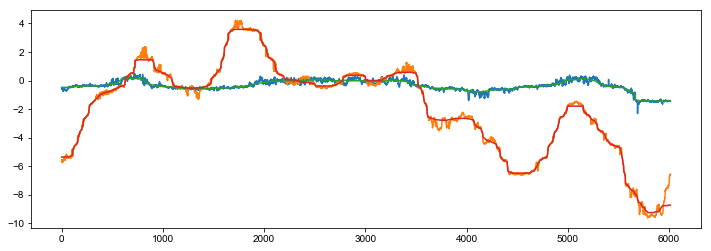

In [3]:
data = dset.data
exp_name = base_dir.split('/')[-2]
reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
reg_path = reg_dir + 'regparams_affine.npy'
fs_im = dset.metadata['volume_rate']
shifts = -np.load(reg_path)[:,:-1,-1]

fig, axs = plt.subplots(figsize=(12,4))
axs.plot(shifts)
shifts_filt = median_filter(shifts, size=(300,1))
axs.plot(shifts_filt)

In [4]:
window_seconds = 300
window_frames = int(window_seconds * fs_im)
camera_baseline = 80

def mybl(v):
    from fish.image.vol import baseline
    window = window_frames
    percentile = 20
    downsample = 1;
    return baseline((v - camera_baseline).clip(1, None), window, percentile, downsample, axis=0).astype('float32')

def mydff(v):
    from fish.image.vol import dff
    window = window_frames
    percentile = 20
    offset = 10    
    downsample = 1;
    return dff((v - camera_baseline).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def mydff_dst(v):
    from fish.image.vol import dff
    window = window_frames
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_baseline).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')


In [5]:
from fish.util.distributed import get_jobqueue_cluster
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

<Client: scheduler='tcp://10.36.60.32:41467' processes=0 cores=0>

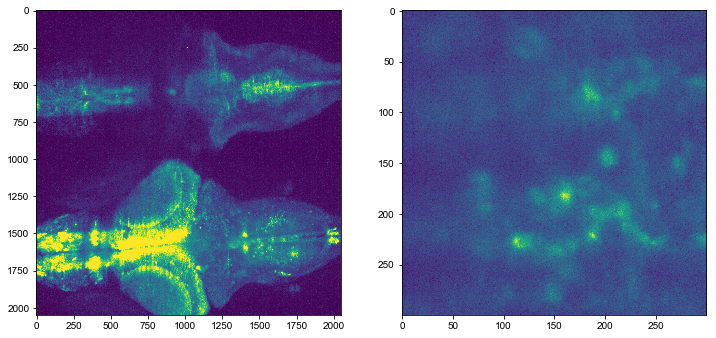

In [6]:
full_sample = data[:10].mean(0).compute(scheduler='threads')
fig, axs = plt.subplots(ncols=2, figsize=(12,12))
roi = slice(None), slice(10,11,1), slice(1400,1700), slice(1360,1660)

axs[0].imshow(full_sample.max(0), clim=(100,150))
axs[1].imshow(full_sample[roi[1:]].max(0))

In [ ]:
%%time
cluster.start_workers(30)
keyframes = np.linspace(0, data.shape[0]-1, 24).astype('int')
data_filt = data[roi].astype('float32').map_blocks(lambda v: median_filter(v, size=(1,1,3,3)), dtype='float32')
data_tx = data_filt.map_blocks(shift_yx, shifts, dtype='float32').persist()
sample_tx = data_tx.compute().squeeze()

bl_ds = get_downsampled_baseline(keyframes, data_tx, perc=20, window=300 * fs_im)
bl_ds = np.array([bl.compute() for bl in bl_ds]).squeeze()
cluster.stop_all_jobs()

In [ ]:
subroi = slice(None), slice(50,150), slice(25, 125)
rect1 = rect(*rect_from_slices(roi[-2:], full_sample.max(0).shape), fill=False, edgecolor='y')
rect2 = rect(*rect_from_slices(subroi[-2:], sample_tx.max(0).shape), fill=False, edgecolor='y')

fig, axs = plt.subplots(nrows=3, figsize=(12,12), dpi=200)
axs[0].imshow(full_sample.max(0), origin='lower', cmap='gray', clim=(90,150))
axs[0].add_patch(rect1)
axs[1].imshow(sample_tx.max(0), origin='lower', cmap='gray')
axs[1].add_patch(rect2)
axs[2].imshow(sample_tx[subroi].max(0), origin='lower', cmap='gray')

In [ ]:
fig, axs = plt.subplots(figsize=(8,6), dpi=200)

x_true = np.linspace(.05, 1, 100)
y_true = x_true ** -1.001
y_true /= y_true.max()
ds_inds = np.linspace(0,x_true.shape[0]-1, 10).astype('int')
x_ds = x_true[ds_inds]
y_intp = interp1d(x_ds, y_true[ds_inds], bounds_error=False)
axs.plot(x_true,y_true,'k:', label='True value')
axs.plot(x_ds, y_true[ds_inds],'o', label='Sampled value')
axs.plot(x_true, y_intp(x_true),'y-', label='Linearly interpolated value')
axs.legend()
axs_format(axs)

In [ ]:
%%time
bl_sub_full = mybl(sample_tx[subroi])
bl_sub_ds = bl_ds[:,subroi[1],subroi[2]]
samp_sub = sample_tx[subroi]

In [ ]:
fig, axs = plt.subplots(figsize=(12,12), nrows=3, dpi=200, sharex=True)
ims = []
interper = interp1d(keyframes, bl_sub_ds, axis=0, kind=1)

plr = slice(0, 2000)
x_t = np.arange(samp_sub[plr].shape[0]) / fs_im
order = np.argsort(redim(samp_sub, ndim=2).max(0))[::-1][::10]
ext = extent=(0,x_t[-1], 0, len(order))
raw2d = redim(samp_sub, ndim=2).T 
bl2d = redim(bl_sub_full, ndim=2).T
interp2d = redim(interper(range(bl_sub_full.shape[0])), ndim=2).T

ims.append(axs[0].imshow(raw2d[order,plr] - camera_baseline, extent=ext, cmap='gray', clim=(None,60)))
axs[0].title.set_text('Raw pixel timeseries, sorted by max intensity')

ims.append(axs[1].imshow(bl2d[order,plr], extent=ext, cmap='gray'))
axs[1].title.set_text('Sliding window baseline')

ims.append(axs[2].imshow(interp2d[order,plr] - camera_baseline, extent=ext, clim=ims[1].get_clim(), cmap='gray'))
axs[2].title.set_text(f'Linearly interpolated baseline estimated from {len(keyframes)} points')
axs[2].set_xlabel('Time (s)')

dividers = [make_axes_locatable(ax) for ax in axs]
caxs = [divider.append_axes("right", size="5%", pad=0.05) for divider in dividers]
[plt.colorbar(ims[ind], cax=cax) for ind, cax in enumerate(caxs)]

plt.subplots_adjust(wspace=0, hspace=.15)

In [ ]:
x = keyframes.clip(0, data.shape[0]-1)
interper_1 = interp1d(x, bl_sub_ds - 80, axis=0, kind=1)
interper_3 = interp1d(x, bl_sub_ds - 80, axis=0, kind='cubic')

plr = slice(0, None)
x_t = np.arange(samp_sub.shape[0])[plr] / fs_im

order = np.argsort(redim(samp_sub, 2).max(0))[::-1][::3000]
raw2d = redim(samp_sub, 2).clip(None,120) - camera_baseline
bl2d = redim(bl_sub_full, 2)
interp_1_2d = redim(interper_1(range(bl_sub_full.shape[0])),2)
interp_3_2d=  redim(interper_1(range(bl_sub_full.shape[0])),2)
offset = 15 * np.arange(raw2d[plr,order].shape[1])

fig, axs = plt.subplots(figsize=(12,8), nrows=1, dpi=200)
lines = []
lines.append(axs.plot(x_t, raw2d[plr, order] - offset, color=(.7,.7,.7), label='Raw fluorescence'))
lines.append(axs.plot(x_t, bl2d[plr, order] - offset,'b', label='Point-estimate baseline'))
lines.append(axs.plot(x_t, interp_1_2d[plr, order] - offset,'k', label='Linear-interpolated baseline'))
lines.append(axs.plot(x_t, interp_3_2d[plr, order] - offset,'r:', label='Cubic spline-interpolated baseline'))
axs.legend(handles = [l[0] for l in lines])
scbx = np.array([0, window_seconds])
scby = np.array(2*[min(axs.get_ylim())])
axs.plot(scbx,scby, color='k', linewidth=3)
axs.text(scbx[0], scby[0] + 1, 'Window used for baseline estimation')
axs.set_xlabel('Time (s)')
axs.title.set_text('Sample raw traces with point-estimate baseline and interpolated baselines')
axs_format(axs)

In [ ]:
num_interp_vals = np.arange(4,40,4)
fig, axs = plt.subplots(nrows=len(num_interp_vals), sharex=True, figsize=(6,6), dpi=200)
def mse(a,b):
    return (a - b)**2

for ind, n in enumerate(num_interp_vals):
    step = int(data.shape[0] / fs_im) // n
    x = np.linspace(0, data.shape[0]-1, n).astype('int')
    interp_1 = interp1d(x, bl_sub_full[x], axis=0, kind=1)
    interp_3 = interp1d(x, bl_sub_full[x], axis=0, kind='cubic')
    
    bl2d = redim(bl_sub_full,2).T
    interp2d_1 = redim(interp_1(range(bl_sub_full.shape[0])),2).T
    interp2d_3 = redim(interp_3(range(bl_sub_full.shape[0])),2).T
    axs[ind].hist(mse(bl2d, interp2d_1).mean(1), 100, color='k', histtype='step', label='Linear interpolation', alpha=.8);
    axs[ind].hist(mse(bl2d, interp2d_3).mean(1), 100, color='m', histtype='step', label='Cubic spline interpolation', alpha=.8);
    axs[ind].text(.2, 150, f'{n} points \n{step} s steps', fontsize=12)

axs[0].legend()
axs[0].title.set_text('Mean squared error between point-estimate baseline and interpolated baselines')
axs[-1].set_xlabel('Mean squared error')
[axs_format(ax) for ax in axs]

In [ ]:
# generate df/f from downsampled baseline
interper_ds = interp1d(keyframes, bl_sub_ds - 80, axis=0, kind=1)

dff_sub = (samp_sub - camera_baseline - bl_sub_full) / (bl_sub_full + 1)
dff_sub_ds = (samp_sub - camera_baseline - interper_ds(range(samp_sub.shape[0]))) / (interper_ds(range(samp_sub.shape[0])) + 1)
t = np.argmax(dff_sub.max((1,2)))
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,12), dpi=200)

axs[0,0].imshow(dff_sub[t], cmap='gray', origin='lower')
axs[0,1].imshow(dff_sub_ds[t], clim=axs[0][0].images[0].get_clim(), cmap='gray', origin='lower')
axs[0,0].title.set_text('Point-estimate Δf/f, example frame')
axs[0,1].title.set_text('Downsampled Δf/f, example frame')

axs[1,0].imshow(dff_sub.max(0), cmap='gray', origin='lower')
axs[1,1].imshow(dff_sub_ds.max(0), clim=axs[1][0].images[0].get_clim(), cmap='gray', origin='lower')
axs[1,0].title.set_text('Point-estimate Δf/f, max(time)')
axs[1,1].title.set_text('Downsampled Δf/f, max(time)')

axs[2,0].imshow(dff_sub.min(0), cmap='gray', origin='lower')
axs[2,1].imshow(dff_sub_ds.min(0), clim=axs[2,0].images[0].get_clim(), cmap='gray', origin='lower')
axs[2,0].title.set_text('Point-estimate Δf/f, min(time)')
axs[2,1].title.set_text('Downsampled Δf/f, min(time)')
[ax.axis('off') for ax in axs.ravel()]

ims = [axs[0,1].images[0], axs[1,1].images[0], axs[2,1].images[0]]
dividers = [make_axes_locatable(ax) for ax in axs[:,1]]
caxs = [divider.append_axes("right", size="5%", pad=0.05) for divider in dividers]
[plt.colorbar(ims[ind], cax=cax) for ind, cax in enumerate(caxs)]
plt.subplots_adjust(wspace=0, hspace=.1)

In [ ]:
%%time
cluster.start_workers(300)

# test getting full downsampled baseline
roi = slice(None), slice(None), slice(None), slice(None)

keyframes = np.linspace(0, data.shape[0]-1, 24).astype('int')
medfilt = partial(median_filter, size=(1,1,3,3))
data_filt = data.astype('float32')[roi].map_blocks(medfilt, dtype='float32')

#data_resc = data_filt.map_blocks(resc, dtype='float16')
data_tx = data_filt.map_blocks(shift_yx, shifts_filt, dtype=data_filt.dtype).persist()
bl_chunks = get_downsampled_baseline(keyframes, data_tx, perc=20, window=int(300 * fs_im))
bl_ds_full = np.array([blc.compute() for blc in bl_chunks])
cluster.stop_all_jobs()

In [ ]:
from h5py import File
with File(reg_dir + 'ds_baseline.h5') as f:
    f.create_dataset('baseline', data=bl_ds_full)
    f.create_dataset('keyframes', data=keyframes)
    f.close()    

## Example code for lab meeting

In [35]:
%%time
# define an ROI
roi = slice(None), slice(None), slice(None), slice(None)

# median filter
data_filt = data[roi].astype('float32').map_blocks(lambda v: median_filter(v, size=(1,1,3,3)), dtype='float32')

# motion correction
data_tx = data_filt.map_blocks(shift_yx, shifts, dtype='float32')

# this is our downsampled dff data, defined as a hdf5 file that acts like an in-memory array
baseline_y = da.from_array(File(reg_dir + 'ds_baseline.h5', libver='latest', mode='r')['baseline'], chunks=(1,-1,-1,-1))

# we also saved the specific timepoints used for downsampling
baseline_x = File(reg_dir + 'ds_baseline.h5', mode='r')['keyframes'][:]

# we use the baseline and the timepoints to define an object that acts like an array but returns interpolated values 
# when indexed
dsb = InterpArray(x=baseline_x, y=baseline_y, full_shape=data.shape, interpolation_axis=0)
baseline = dsb[roi]

# because we are using dask, we can define the df/f operation using basic math operators
data_dff = (data_tx / baseline) - 1

CPU times: user 14.7 s, sys: 68.5 ms, total: 14.7 s
Wall time: 14.7 s


In [36]:
data_dff.shape

(6013, 22, 2048, 2048)

## Get Δf/f image of first and last timepoints at full resolution using a single worker (no distributed computation)

In [37]:
%%time
# this does everything -- load, filter, align, normalize, all for one image
dff_first = data_dff[0].compute(scheduler='threads')

CPU times: user 35.7 s, sys: 1.35 s, total: 37.1 s
Wall time: 36.4 s


In [38]:
%%time
dff_last = data_dff[-1].compute(scheduler='threads')

CPU times: user 37.4 s, sys: 2.76 s, total: 40.2 s
Wall time: 37.1 s


## Show max projections of Δf/f volumes

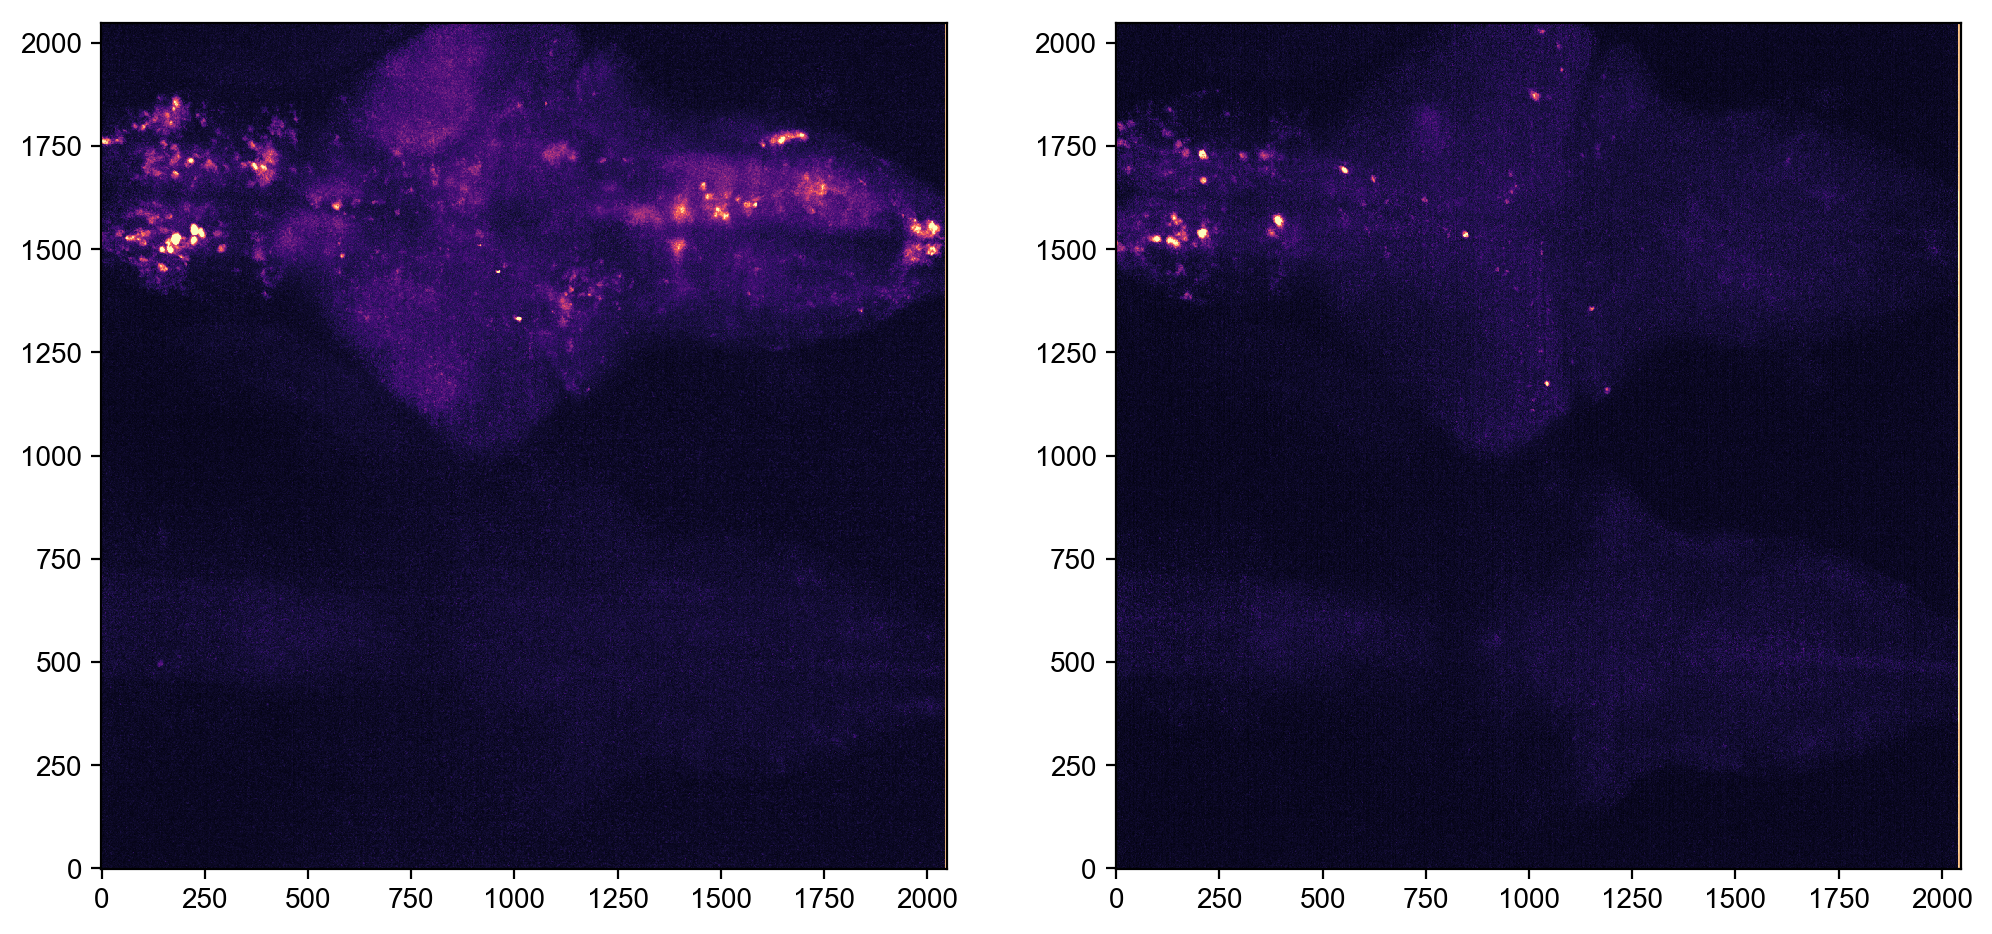

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(12,12), dpi=200)
axs[0].imshow(dff_first.max(0), clim=(0,.4), cmap='magma', origin='lower')
axs[1].imshow(dff_last.max(0), clim=axs[0].images[0].get_clim(), cmap='magma', origin='lower')